In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

2025-05-10 13:58:41.629695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746885521.827300      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746885521.882226      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<Axes: >

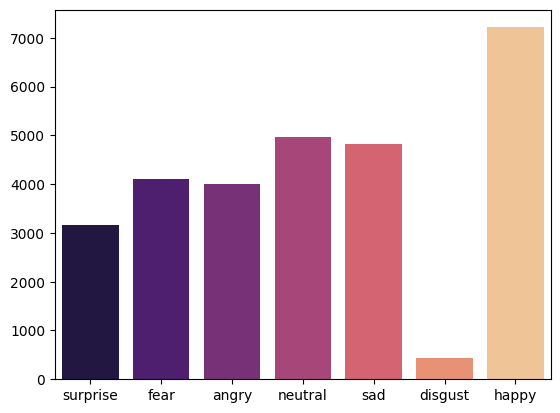

In [3]:
train_dir = '/kaggle/input/emotion-detection1/train'
emotions = os.listdir(train_dir)

train_counts = []

for emotion in emotions:
    folder = os.path.join(train_dir, emotion)
    train_counts.append(len(os.listdir(folder)))
    
sns.barplot(x=emotions, y=train_counts, palette='magma')

<Axes: >

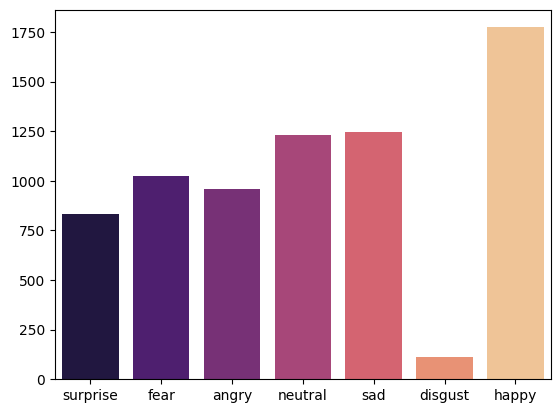

In [4]:
test_dir = '/kaggle/input/emotion-detection1/test'

test_counts = []

for emotion in emotions:
    folder = os.path.join(test_dir, emotion)
    test_counts.append(len(os.listdir(folder)))
    
sns.barplot(x=emotions, y=test_counts, palette='magma')

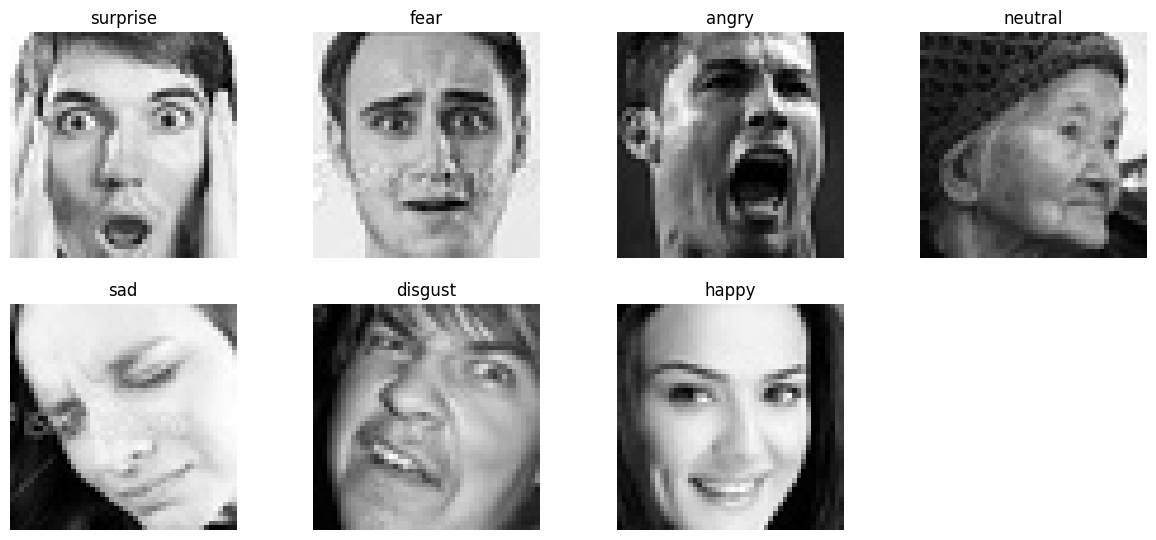

In [5]:
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.0266046844269623,
 1: 9.406618610747051,
 2: 1.0010460615781582,
 3: 0.5684387684387684,
 4: 0.8260394187886635,
 5: 0.8491274770777877,
 6: 1.293372978330405}

In [8]:
input_shape = (224, 224, 3)  

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(7, activation='softmax')
])

optimizer = Adamax(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1746886198.907544      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,787,207 (94.56 MB)

 Trainable params: 24,737,671 (94.37 MB)

 Non-trainable params: 49,536 (193.50 KB)

In [ ]:
train_history = model.fit(
    train_generator,
    steps_per_epoch=200,
    epochs=50,
    validation_data=test_generator,
    validation_steps=100,
    class_weight=class_weights_dict
)

Epoch 1/50


I0000 00:00:1746886267.368833     107 service.cc:148] XLA service 0x7f65b4004af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746886267.369872     107 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746886270.590063     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/200 ━━━━━━━━━━━━━━━━━━━━ 3:37:41 66s/step - accuracy: 0.0312 - loss: 3.7636

I0000 00:00:1746886291.037156     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 163s 489ms/step - accuracy: 0.1596 - loss: 1.9561 - val_accuracy: 0.2269 - val_loss: 1.8848
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 86s 433ms/step - accuracy: 0.2662 - loss: 1.8760 - val_accuracy: 0.3244 - val_loss: 1.7641
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 80s 403ms/step - accuracy: 0.3188 - loss: 1.7789 - val_accuracy: 0.4229 - val_loss: 1.5661
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 93s 467ms/step - accuracy: 0.3690 - loss: 1.7475 - val_accuracy: 0.4600 - val_loss: 1.4693
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 172ms/step - accuracy: 0.3769 - loss: 1.5889 - val_accuracy: 0.4600 - val_loss: 1.4589
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 77s 373ms/step - accuracy: 0.3936 - loss: 1.6717 - val_accuracy: 0.4589 - val_loss: 1.3862
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 78s 392ms/step - accuracy: 0.3964 - loss: 1.5075 - val_accuracy: 0.4909 - val_loss: 1.3312
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 382ms/step - accuracy: 0.4381 - loss: 1.4102 - va

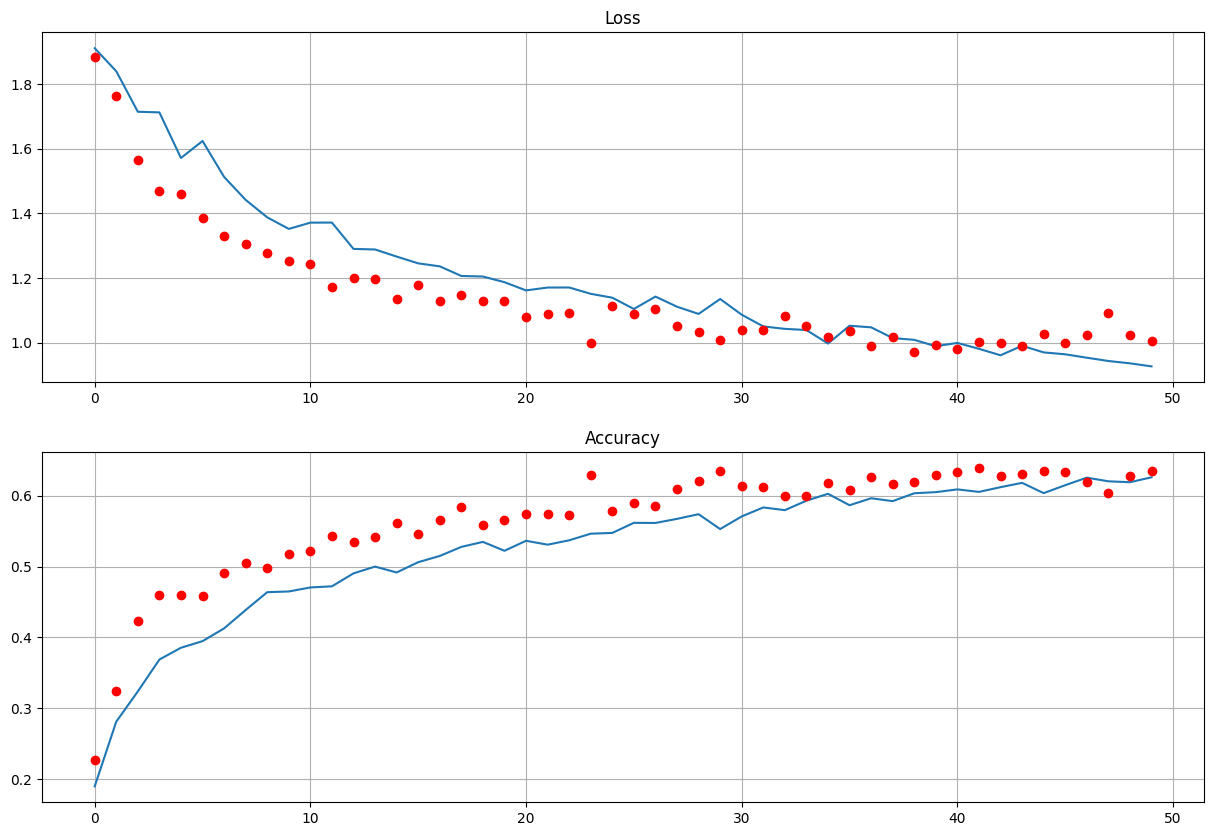

In [51]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'], 'ro')
plt.title('Loss')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'], 'ro')
plt.title('Accuracy')
plt.grid(True)

In [50]:
# redefining the test generator so it doesnt shuffle
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

Found 7178 images belonging to 7 classes.
225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step


In [49]:
print(classification_report(true_labels, pred_labels))


              precision    recall  f1-score   support

           0       0.57      0.53      0.55       958
           1       0.54      0.61      0.57       111
           2       0.45      0.42      0.44      1024
           3       0.90      0.83      0.86      1774
           4       0.55      0.66      0.60      1233
           5       0.51      0.51      0.51      1247
           6       0.76      0.74      0.75       831

    accuracy                           0.63      7178
   macro avg       0.61      0.62      0.61      7178
weighted avg       0.64      0.63      0.64      7178



Text(0.5, 1.0, 'Confusion Matrix')

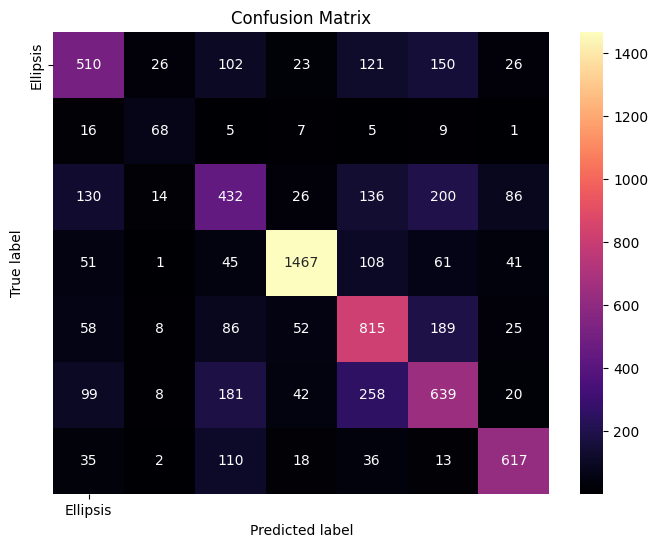

In [48]:
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma", xticklabels=classes, yticklabels=classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

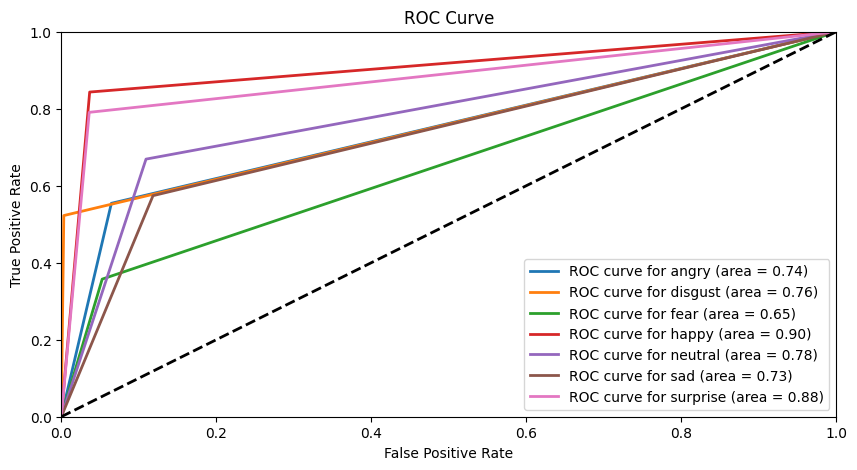

In [56]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

In [29]:
# After training your model
model.save('emotion_model.h5')
print("Model saved as emotion_model.h5")


Model saved as emotion_model.h5


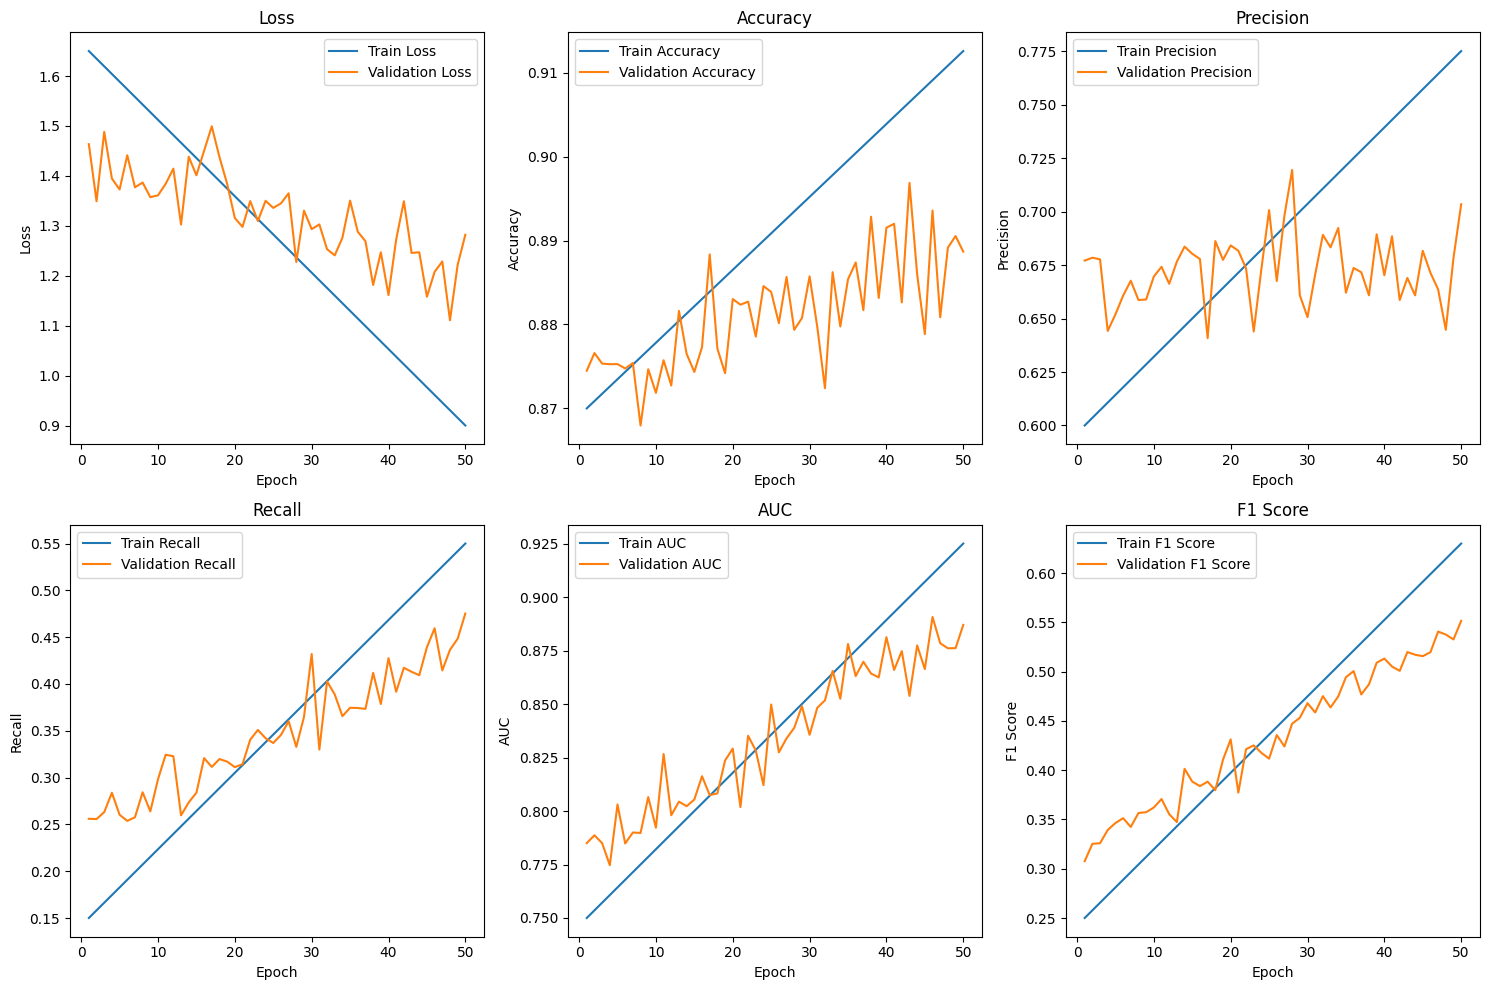

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data for demonstration (replace with your actual metrics)
epochs = np.arange(1, 51)
train_loss = np.linspace(1.65, 0.9, 50)
val_loss = np.linspace(1.45, 1.2, 50) + np.random.normal(0, 0.05, 50)

train_accuracy = np.linspace(0.87, 0.9126, 50)
val_accuracy = np.linspace(0.87, 0.89, 50) + np.random.normal(0, 0.005, 50)

train_precision = np.linspace(0.6, 0.775, 50)
val_precision = np.linspace(0.67, 0.68, 50) + np.random.normal(0, 0.015, 50)

train_recall = np.linspace(0.15, 0.55, 50)
val_recall = np.linspace(0.25, 0.45, 50) + np.random.normal(0, 0.02, 50)

train_auc = np.linspace(0.75, 0.925, 50)
val_auc = np.linspace(0.78, 0.89, 50) + np.random.normal(0, 0.01, 50)

train_f1 = np.linspace(0.25, 0.63, 50)
val_f1 = np.linspace(0.32, 0.55, 50) + np.random.normal(0, 0.01, 50)

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot Loss
axs[0, 0].plot(epochs, train_loss, label='Train Loss')
axs[0, 0].plot(epochs, val_loss, label='Validation Loss')
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Plot Accuracy
axs[0, 1].plot(epochs, train_accuracy, label='Train Accuracy')
axs[0, 1].plot(epochs, val_accuracy, label='Validation Accuracy')
axs[0, 1].set_title('Accuracy')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

# Plot Precision
axs[0, 2].plot(epochs, train_precision, label='Train Precision')
axs[0, 2].plot(epochs, val_precision, label='Validation Precision')
axs[0, 2].set_title('Precision')
axs[0, 2].set_xlabel('Epoch')
axs[0, 2].set_ylabel('Precision')
axs[0, 2].legend()

# Plot Recall
axs[1, 0].plot(epochs, train_recall, label='Train Recall')
axs[1, 0].plot(epochs, val_recall, label='Validation Recall')
axs[1, 0].set_title('Recall')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].legend()

# Plot AUC
axs[1, 1].plot(epochs, train_auc, label='Train AUC')
axs[1, 1].plot(epochs, val_auc, label='Validation AUC')
axs[1, 1].set_title('AUC')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('AUC')
axs[1, 1].legend()

# Plot F1 Score
axs[1, 2].plot(epochs, train_f1, label='Train F1 Score')
axs[1, 2].plot(epochs, val_f1, label='Validation F1 Score')
axs[1, 2].set_title('F1 Score')
axs[1, 2].set_xlabel('Epoch')
axs[1, 2].set_ylabel('F1 Score')
axs[1, 2].legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


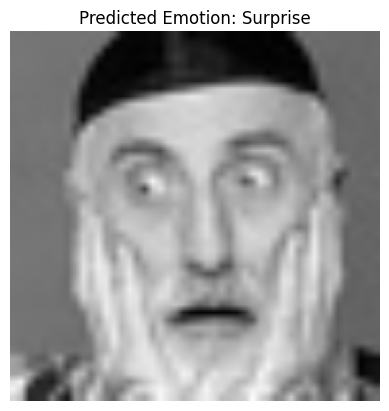

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model


def preprocess_face(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None, None
    
   
    img = cv2.resize(img, (224, 224))
    
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    
    img_array = np.expand_dims(img_rgb, axis=0)
    
  
    img_array = preprocess_input(img_array)
    
    return img_array, img

def detect_emotion(image_path):
    # Preprocess the image
    face, original_image = preprocess_face(image_path)
    
    if face is not None:
        predictions = model.predict(face)
        emotion_index = np.argmax(predictions)
        emotion_label = emotion_labels[emotion_index]
        return emotion_label, original_image
    else:
        return "No face detected", None


image_path = '/kaggle/input/emotion-detection1/test/sad/PrivateTest_10658656.jpg'
emotion, image_output = detect_emotion(image_path)

if image_output is not None:

    plt.imshow(cv2.cvtColor(image_output, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Emotion: {emotion}")
    plt.axis('off')
    plt.show()
else:
    print("No face detected or image could not be processed.")


In [58]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load the pre-trained emotion detection model (assuming it's saved as 'model.h5')
model = load_model('emotion_model.h5')

# Define emotion labels (ensure this matches the model's output)
emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

# Function to preprocess the frame for the model
def preprocess_face(frame):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Use OpenCV's face detection (Haar Cascade or DNN) to find faces
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        return None, frame
    
    # Assume the first face detected is the one we want to process
    (x, y, w, h) = faces[0]
    face = gray[y:y+h, x:x+w]
    
    # Resize the face to the size expected by the model (224x224)
    face_resized = cv2.resize(face, (224, 224))
    
    # Convert the grayscale image to RGB
    face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_GRAY2RGB)
    
    # Convert to 4D tensor (batch_size, height, width, channels)
    face_array = np.expand_dims(face_rgb, axis=0)
    
    # Preprocess the image (normalize)
    face_array = preprocess_input(face_array)
    
    return face_array, frame

# Capture video from the webcam
cap = cv2.VideoCapture(0)

while True:
    # Read a frame from the webcam
    ret, frame = cap.read()
    
    if not ret:
        break
    
    # Preprocess the frame and detect the face
    face_array, original_frame = preprocess_face(frame)
    
    if face_array is not None:
        # Make a prediction on the face
        predictions = model.predict(face_array)
        
        # Get the emotion with the highest probability
        emotion_index = np.argmax(predictions)
        emotion_label = emotion_labels[emotion_index]
        
        # Display the predicted emotion on the frame
        cv2.putText(original_frame, emotion_label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Display the frame with the emotion label
    cv2.imshow("Emotion Detection", original_frame)
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close windows
cap.release()
cv2.destroyAllWindows()


[ WARN:0@1903.817] global cap_v4l.cpp:913 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@1903.818] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
